In [1]:
!pip install bnlp_toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=c58ea69cd7655f2db6ec105a4c0e6bf73f4309e4522dd1df81cb95cffa7d7165
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.10.0
    Uninstalling emoji-2.10.0:
      Successfully uninstalled emoji-2.10.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from bnlp import NLTKTokenizer

In [3]:
df_train = pd.read_excel("/kaggle/input/spell-dataset/bemoc_clean.xlsx")

In [4]:
df_train.head()

,TEXT,classes
0,নাইমা কি করবেন আমরা জানি,sadness
1,ভাই সব আপনাদের খুব ভাল লাগছে,joy
2,গাঞ্জা খাইয়া নিউজ শেয়ার করছে দিগন্ত বয়কটে ...,anger
3,অনেক ধন্যবাদ স্যার যশোরে ইত্যাদি অনুষ্ঠান করা...,joy
4,বর্তমানে মুসলমান মারে যে জন সে জন হয়েছে ঈশ্বর,disgust


In [5]:
df_train.dropna(inplace=True)

In [6]:
longest_string = max(df_train["TEXT"], key=len)
print(len(longest_string))

1067


In [7]:
df_train['classes'].value_counts()

classes
joy         1524
disgust     1356
sadness     1327
anger       1052
fear         962
surprise     779
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_train, test_size=0.2,stratify=df_train['classes'],random_state=42)

In [9]:
X_train  =  train_df['TEXT'].values.tolist()
y_train = train_df['classes'].tolist()

In [10]:
X_test =  test_df['TEXT'].values.tolist()
y_test = test_df['classes'].tolist()

In [11]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 53.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 43.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 11.5 MB/s eta 0:00:00
  Created wheel for ktrain: filename=ktrain-0.40.0-py3-none-any.whl size=25319454 sha256=2f8b94b0bd54f31fd85a511649059a563335384e5968f32564a03ea1ebbf0d53
  Stored in directory: /roo

In [12]:
import ktrain
from ktrain import text
MODEL_NAME = 'FacebookAI/xlm-roberta-base'
t = text.Transformer(MODEL_NAME, maxlen=500)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [13]:
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: bn
train sequence lengths:
	mean : 21
	95percentile : 41
	99percentile : 57


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 21
	95percentile : 41
	99percentile : 61


In [14]:
print(trn)

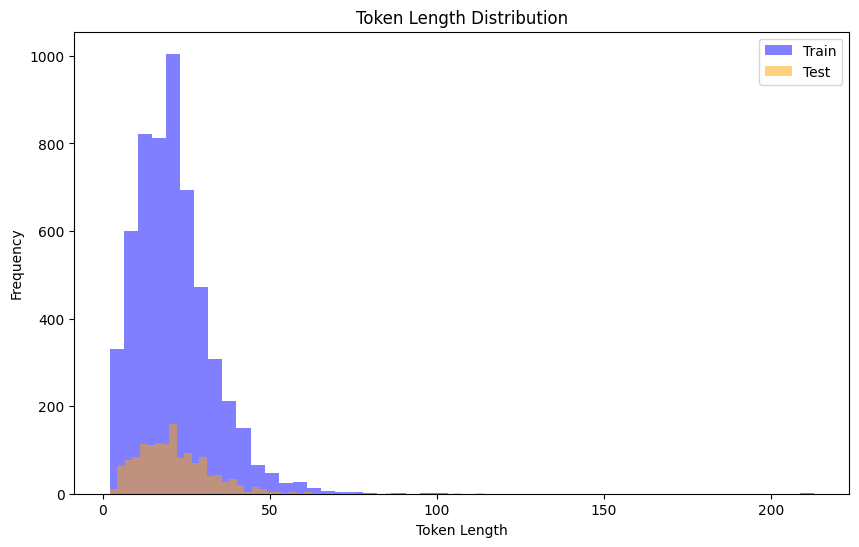

In [15]:
import matplotlib.pyplot as plt

# Calculate token lengths for train and test datasets
train_token_lengths = [len(t.split()) for t in X_train]
test_token_lengths = [len(t.split()) for t in X_test]

# Plot token length distribution
plt.figure(figsize=(10, 6))
plt.hist(train_token_lengths, bins=50, alpha=0.5, color='blue', label='Train')
plt.hist(test_token_lengths, bins=50, alpha=0.5, color='orange', label='Test')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
plt.show()

In [16]:
model = t.get_classifier()

In [17]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=8)

In [18]:
# Adding early stopping callback from TensorFlow
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='accuracy', patience=5, mode='auto')

In [19]:
history = learner.fit_onecycle(2e-5, 10,callbacks=[early_stopping])



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
700/700 [==============================] - 461s 620ms/step - loss: 1.6666 - accuracy: 0.2900 - val_loss: 1.2591 - val_accuracy: 0.4750
Epoch 2/10
700/700 [==============================] - 429s 614ms/step - loss: 1.1758 - accuracy: 0.5625 - val_loss: 1.0590 - val_accuracy: 0.5879
Epoch 3/10
700/700 [==============================] - 430s 614ms/step - loss: 1.0140 - accuracy: 0.6121 - val_loss: 1.0439 - val_accuracy: 0.6021
Epoch 4/10
700/700 [==============================] - 430s 614ms/step - loss: 0.8904 - accuracy: 0.6654 - val_loss: 1.0738 - val_accuracy: 0.6257
Epoch 5/10
700/700 [==============================] - 429s 613ms/step - loss: 0.7939 - accuracy: 0.6964 - val_loss: 1.0305 - val_accuracy: 0.6257
Epoch 6/10
700/700 [==============================] - 429s 613ms/step - loss: 0.6798 - accuracy: 0.7414 - val_loss: 1.0410 - val_accuracy: 0.6314
Epoch 7/10
700/700 [==============================] - 429s 61

In [20]:
# Save the trained model
learner.save_model('/kaggle/output/bemoc.zip')

In [21]:
classes=t.get_classes()

In [22]:
cm = learner.validate(class_names=t.get_classes())

44/44 [==============================] - 15s 268ms/step
              precision    recall  f1-score   support

       anger       0.53      0.47      0.50       211
     disgust       0.50      0.49      0.50       271
        fear       0.72      0.82      0.77       192
         joy       0.80      0.79      0.79       305
     sadness       0.63      0.69      0.66       265
    surprise       0.66      0.58      0.62       156

    accuracy                           0.65      1400
   macro avg       0.64      0.64      0.64      1400
weighted avg       0.64      0.65      0.64      1400

